# Attempt to prune a Decision Tree in sklearn

Include needed imports.

In [ ]:
%reload_ext autoreload
%autoreload 2
import threadpoolctl
import matplotlib as mpl
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import train_test_split
from copy import deepcopy
import matplotlib.pyplot as plt
from intellect.inspect import set_seed

threadpoolctl.threadpool_limits(limits=2);
mpl.rcParams['figure.dpi']= 70
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 20)

Load data and split into train-test portions.

In [5]:
set_seed()

iris = load_iris()
X, y = iris.data, iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Create and fit a DecisionTreeClassifier.

In [10]:
set_seed()
original_tree = DecisionTreeClassifier()
original_tree.fit(X_train, y_train);

Test the obtained tree.

In [22]:
original_tree.score(X_test, y_test)

1.0

Display the obtained Decision Tree Rules and plot the tree.

In [11]:
original_tree_rules = export_text(original_tree, feature_names=iris.feature_names)
print("Original Decision Tree:")
print(original_tree_rules)

Original Decision Tree:
|--- petal length (cm) <= 2.45
|   |--- class: 0
|--- petal length (cm) >  2.45
|   |--- petal length (cm) <= 4.75
|   |   |--- petal width (cm) <= 1.65
|   |   |   |--- class: 1
|   |   |--- petal width (cm) >  1.65
|   |   |   |--- class: 2
|   |--- petal length (cm) >  4.75
|   |   |--- petal width (cm) <= 1.75
|   |   |   |--- petal length (cm) <= 4.95
|   |   |   |   |--- class: 1
|   |   |   |--- petal length (cm) >  4.95
|   |   |   |   |--- petal width (cm) <= 1.55
|   |   |   |   |   |--- class: 2
|   |   |   |   |--- petal width (cm) >  1.55
|   |   |   |   |   |--- petal length (cm) <= 5.45
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- petal length (cm) >  5.45
|   |   |   |   |   |   |--- class: 2
|   |   |--- petal width (cm) >  1.75
|   |   |   |--- petal length (cm) <= 4.85
|   |   |   |   |--- sepal width (cm) <= 3.10
|   |   |   |   |   |--- class: 2
|   |   |   |   |--- sepal width (cm) >  3.10
|   |   |   |   |   |--- class: 1

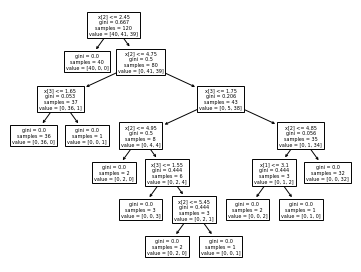

In [13]:
plot_tree(original_tree);

## Option 1: Train from scratch setting cost-complexity pruning during training phase

Setting ccp_alpha to a positive value encourages pruning

In [15]:
set_seed()
pruned_tree_retrained = DecisionTreeClassifier(ccp_alpha=0.01)
pruned_tree_retrained.fit(X_train, y_train);

Test the obtained tree.

In [20]:
pruned_tree_retrained.score(X_test, y_test)

1.0

In [17]:
# Display the pruned decision tree
pruned_tree_rules = export_text(pruned_tree_retrained, feature_names=iris.feature_names)
print("\nPruned Decision Tree:")
print(pruned_tree_rules)


Pruned Decision Tree:
|--- petal length (cm) <= 2.45
|   |--- class: 0
|--- petal length (cm) >  2.45
|   |--- petal length (cm) <= 4.75
|   |   |--- petal width (cm) <= 1.65
|   |   |   |--- class: 1
|   |   |--- petal width (cm) >  1.65
|   |   |   |--- class: 2
|   |--- petal length (cm) >  4.75
|   |   |--- petal width (cm) <= 1.75
|   |   |   |--- petal length (cm) <= 4.95
|   |   |   |   |--- class: 1
|   |   |   |--- petal length (cm) >  4.95
|   |   |   |   |--- petal width (cm) <= 1.55
|   |   |   |   |   |--- class: 2
|   |   |   |   |--- petal width (cm) >  1.55
|   |   |   |   |   |--- petal length (cm) <= 5.45
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- petal length (cm) >  5.45
|   |   |   |   |   |   |--- class: 2
|   |   |--- petal width (cm) >  1.75
|   |   |   |--- class: 2



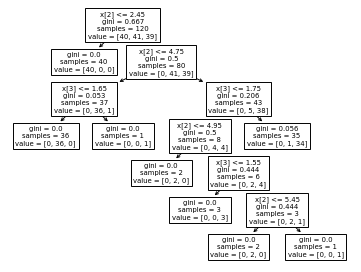

In [19]:
plot_tree(pruned_tree_retrained);

Smarter solution: perform a cost-complexity analysis

In [50]:
set_seed()
clf = DecisionTreeClassifier()
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

And visualize data.

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

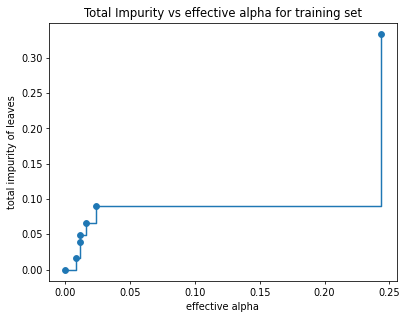

In [51]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

## Option 2: Prune by setting to null some node

Print active children in the left branch.

In [47]:
original_tree.tree_.children_left.tolist()

[1, -1, 3, 4, -1, -1, 7, 8, -1, 10, -1, 12, -1, -1, 15, 16, -1, -1, -1]

Decide to prune the whole sub-tree referring to the 3rd node (index=2).

In [44]:
pruned_tree_derived = deepcopy(original_tree)
pruned_tree_derived.tree_.children_left[2] = -1

Test the obtained tree.

In [45]:
pruned_tree_derived.score(X_test, y_test)

0.6333333333333333

Plot the obtained tree.

In [48]:
# Display the pruned decision tree
pruned_tree_rules_derived = export_text(pruned_tree_derived, feature_names=iris.feature_names)
print("\nPruned Decision Tree:")
print(pruned_tree_rules_derived)


Pruned Decision Tree:
|--- petal length (cm) <= 2.45
|   |--- class: 0
|--- petal length (cm) >  2.45
|   |--- petal length (cm) <= 4.75
|   |   |--- class: 2
|   |--- petal length (cm) >  4.75
|   |   |--- petal width (cm) <= 1.75
|   |   |   |--- petal length (cm) <= 4.95
|   |   |   |   |--- class: 1
|   |   |   |--- petal length (cm) >  4.95
|   |   |   |   |--- petal width (cm) <= 1.55
|   |   |   |   |   |--- class: 2
|   |   |   |   |--- petal width (cm) >  1.55
|   |   |   |   |   |--- petal length (cm) <= 5.45
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- petal length (cm) >  5.45
|   |   |   |   |   |   |--- class: 2
|   |   |--- petal width (cm) >  1.75
|   |   |   |--- petal length (cm) <= 4.85
|   |   |   |   |--- sepal width (cm) <= 3.10
|   |   |   |   |   |--- class: 2
|   |   |   |   |--- sepal width (cm) >  3.10
|   |   |   |   |   |--- class: 1
|   |   |   |--- petal length (cm) >  4.85
|   |   |   |   |--- class: 2



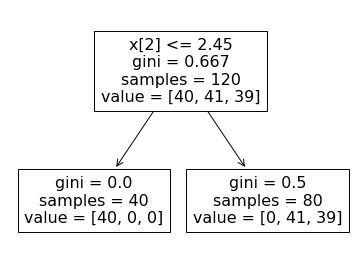

In [49]:
plot_tree(pruned_tree_derived);